<a href="https://colab.research.google.com/github/joaochenriques/IST_MCTE/blob/main/StreamTurbines/Variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mpl
import pathlib, subprocess

def cmdcall( cmd ):
    output = subprocess.getoutput( cmd )
    print(output)

In [2]:
if not pathlib.Path("mpl_utils.py").exists():
  cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" )

import mpl_utils as mut
mut.config_plots()

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  3921  100  3921    0     0  14314      0 --:--:-- --:--:-- --:--:-- 14362


In [3]:
def funcs( a ):
    p0m = a * ( +2.0 - a )
    p0p = a * ( -2.0 + 3.0 * a )
    V0 = ( 1.0 - a )
    V2 = ( 1.0 - 2.0 * a )
    Delta_p = p0m - p0p
    A0A1 = 1.0 / ( 1.0 - a )
    A2A1 = 1.0 / ( 1.0 - 2.0*a )
    return Delta_p, p0m, p0p, V0, V2, A0A1, A2A1

In [4]:
num = 400
a_vec = np.linspace( 0., 0.49, num )
p0m_vec = np.zeros( num )
p0p_vec = np.zeros( num )
Delta_p_vec = np.zeros( num )
V0_vec = np.zeros( num )
V2_vec = np.zeros( num )
A0A1_vec = np.zeros( num )
A2A1_vec = np.zeros( num )

for i, a in enumerate( a_vec ):
    Delta_p_vec[i], p0m_vec[i], p0p_vec[i], V0_vec[i], V2_vec[i], A0A1_vec[i], A2A1_vec[i] = funcs( a )

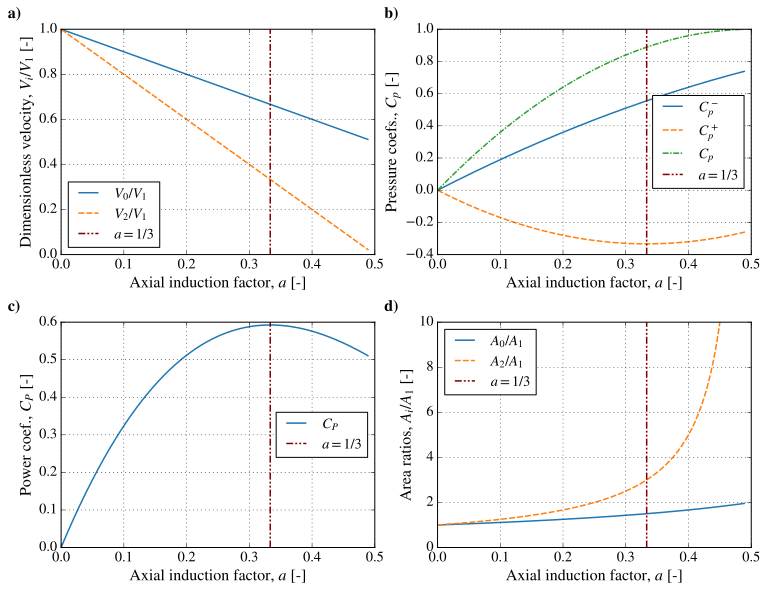

In [11]:
mpl.figure(1, figsize=(16*2/3.,1.8*4.5))
mpl.subplots_adjust(left=0.08, bottom=0.07, right=0.98, top=0.96,
                    wspace=.2, hspace=.3)

mpl.subplot(221)
mpl.plot( a_vec, V0_vec, label = '$V_0/V_1$' )
mpl.plot( a_vec, V2_vec, label = '$V_2/V_1$' )
mpl.axvline( 1.0/3.0, color='#800000', dashes=(7,2,2,2,2,2), label='$a=1/3$' )
mpl.ylabel( 'Dimensionless velocity, $V_i/V_1$ [-]' )
mpl.xlabel( 'Axial induction factor, $a$ [-]' )
mpl.legend( loc='lower left' )
mpl.grid()
mpl.gca().text(-0.17, 1.05, 'a)', transform=mpl.gca().transAxes, size=16, weight='semibold')

mpl.subplot(222)
mpl.plot( a_vec, p0m_vec, label = '$C_p^-$' )
mpl.plot( a_vec, p0p_vec, label = '$C_p^+$' )
mpl.plot( a_vec, Delta_p_vec, label = '$C_p$' )
mpl.axvline( 1.0/3.0, color='#800000', dashes=(7,2,2,2,2,2), label='$a=1/3$' )
mpl.ylabel( 'Pressure coefs., $C_p$ [-]' )
mpl.xlabel( 'Axial induction factor, $a$ [-]' )
mpl.legend( loc='center right')
mpl.grid()
mpl.gca().text(-0.17, 1.05, 'b)', transform=mpl.gca().transAxes, size=16, weight='semibold')

mpl.subplot(223)
mpl.plot( a_vec, Delta_p_vec*(1.0-a_vec), label='$C_P$' )
mpl.axvline( 1.0/3.0, color='#800000', dashes=(7,2,2,2,2,2), label='$a=1/3$' )
mpl.ylabel( 'Power coef., $C_P$ [-]' )
mpl.xlabel( 'Axial induction factor, $a$ [-]' )
mpl.legend( loc='center right')
mpl.grid()
mpl.gca().text(-0.17, 1.05, 'c)', transform=mpl.gca().transAxes, size=16, weight='semibold')

mpl.subplot(224)
mpl.plot( a_vec, A0A1_vec, label = '$A_0/A_1$' )
mpl.plot( a_vec, A2A1_vec, label = '$A_2/A_1$' )
mpl.axvline( 1.0/3.0, color='#800000', dashes=(7,2,2,2,2,2), label='$a=1/3$' )
mpl.ylabel( 'Area ratios, $A_i/A_1$ [-]' )
mpl.xlabel( 'Axial induction factor, $a$ [-]' )
mpl.legend( loc='upper left')
mpl.grid()
mpl.ylim( 0,10 )
mpl.gca().text(-0.17, 1.05, 'd)', transform=mpl.gca().transAxes, size=16, weight='semibold')

mpl.savefig( 'Variables_V3.pdf')